In [243]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [244]:
import pandas as pd
import numpy as np
import datetime as dt
import plotly.express as px
import plotly.graph_objects as go


#for quick viz
import seaborn as sns

#ml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import random

In [245]:
df = pd.read_csv('auto_insurance_csv.csv')
df.head()

,Unnamed: 0,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,0,328,48.0,521585,2014-10-17,OH,250/500,1000,1406.91,0.0,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,1,228,42.0,342868,2006-06-27,IN,250/500,2000,1197.22,5000000.0,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,2,134,29.0,687698,2000-09-06,OH,NaN,2000,1413.14,5000000.0,...,NaN,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,3,256,41.0,227811,1990-05-25,IL,NaN,2000,1415.74,6000000.0,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,4,228,44.0,367455,2014-06-06,IL,NaN,1000,1583.91,6000000.0,...,NaN,6500,1300,650,4550,Accura,RSX,2009,N,NaN


In [246]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 41 columns):
Unnamed: 0                     1000 non-null int64
months_as_customer             1000 non-null int64
age                            865 non-null float64
policy_number                  1000 non-null int64
policy_bind_date               1000 non-null object
policy_state                   1000 non-null object
policy_csl                     127 non-null object
policy_deductable              1000 non-null int64
policy_annual_premium          1000 non-null float64
umbrella_limit                 802 non-null float64
insured_zip                    1000 non-null int64
insured_sex                    1000 non-null object
insured_education_level        1000 non-null object
insured_occupation             1000 non-null object
insured_hobbies                1000 non-null object
insured_relationship           1000 non-null object
capital-gains                  1000 non-null int64
capital-loss    

In [247]:
# removing column named _c39 as it contains only null values

df = df.drop(['_c39','Unnamed: 0'], axis = 1)

In [248]:
df['umbrella_limit'] = df.umbrella_limit.fillna("9999")
df.groupby(['umbrella_limit']).agg({'policy_number': 'count'})

,policy_number
umbrella_limit,
-1000000.0,1
0.0,640
2000000.0,3
3000000.0,7
4000000.0,33
5000000.0,35
6000000.0,45
7000000.0,27
8000000.0,6


In [249]:
df['police_report_available'] = df.police_report_available.fillna("MISSING")
df.groupby(['police_report_available']).agg({'policy_number': 'count'})


,policy_number
police_report_available,
?,257
MISSING,250
NO,262
YES,231


In [250]:
df['policy_csl'] = df.policy_csl.fillna("MISSING")
df.groupby(['policy_csl']).agg({'policy_number': 'count'})


,policy_number
policy_csl,
100/300,44
250/500,43
500/1000,40
MISSING,873


In [251]:
df['policy_bind_date'] = pd.to_datetime(df['policy_bind_date'])
df['incident_date'] = pd.to_datetime(df['incident_date'])
df['claim_day_of_policy'] = (df.incident_date -  df.policy_bind_date).dt.days


In [252]:
df['location_check'] = np.nan
df['location_check'] = np.where(df['policy_state'] == df['incident_state'], True, False)

In [253]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
months_as_customer,1000.0,203.954000,115.113174,0.00,115.7500,199.5,276.250,479.00
age,865.0,38.812717,9.123361,19.00,32.0000,38.0,44.000,64.00
policy_number,1000.0,546238.648000,257063.005276,100804.00,335980.2500,533135.0,759099.750,999435.00
policy_deductable,1000.0,1136.000000,611.864673,500.00,500.0000,1000.0,2000.000,2000.00
policy_annual_premium,1000.0,1256.406150,244.167395,433.33,1089.6075,1257.2,1415.695,2047.59
insured_zip,1000.0,501214.488000,71701.610941,430104.00,448404.5000,466445.5,603251.000,620962.00
capital-gains,1000.0,25126.100000,27872.187708,0.00,0.0000,0.0,51025.000,100500.00
capital-loss,1000.0,-26793.700000,28104.096686,-111100.00,-51500.0000,-23250.0,0.000,0.00
incident_hour_of_the_day,1000.0,11.644000,6.951373,0.00,6.0000,12.0,17.000,23.00
number_of_vehicles_involved,1000.0,1.839000,1.018880,1.00,1.0000,1.0,3.000,4.00


In [254]:
for i in df.columns:
    if df[i].dtype == 'object':
        print(i, ":", df[i].nunique())

policy_state : 3
policy_csl : 4
umbrella_limit : 11
insured_sex : 2
insured_education_level : 7
insured_occupation : 14
insured_hobbies : 20
insured_relationship : 6
incident_type : 4
collision_type : 4
incident_severity : 4
authorities_contacted : 5
incident_state : 7
incident_city : 7
incident_location : 1000
property_damage : 3
police_report_available : 4
auto_make : 14
auto_model : 39
fraud_reported : 2


In [255]:
df[['incident_location']]

,incident_location
0,9935 4th Drive
1,6608 MLK Hwy
2,7121 Francis Lane
3,6956 Maple Drive
4,3041 3rd Ave
5,8973 Washington St
6,5846 Weaver Drive
7,3525 3rd Hwy
8,4872 Rock Ridge
9,3066 Francis Ave


In [256]:
df = df.drop(['policy_bind_date','incident_date'],axis=1)

In [257]:
df['fraud_reported'] = df['fraud_reported'].str.replace('Y', '1')
df['fraud_reported'] = df['fraud_reported'].str.replace('N', '0')
df['fraud_reported'] = df['fraud_reported'].astype(int)

In [258]:
df['fraud_reported'].unique()

array([1, 0], dtype=int64)

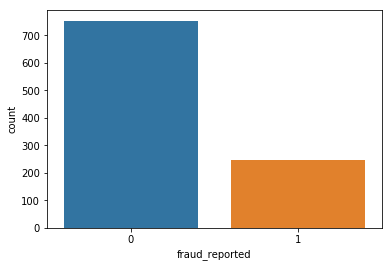

In [259]:
sns.countplot(df['fraud_reported'])

In [260]:
def vis_data(df, x, y = 'fraud_reported', graph = 'countplot'):
    if graph == 'hist':
        fig = px.histogram(df, x = x)
        fig.update_layout(title = 'Distribution of {x}'.format(x = x))
        fig.show()
    elif graph == 'bar':
      fig = px.bar(df, x = x, y = y)
      fig.update_layout(title = '{x} vs. {y}'.format(x = x, y = y))
      fig.show()
    elif graph == 'countplot':
      a = df.groupby([x,y]).count()
      a.reset_index(inplace = True)
      no_fraud = a[a['fraud_reported'] == 0]
      yes_fraud = a[a['fraud_reported'] == 1]
      trace1 = go.Bar(x = no_fraud[x], y = no_fraud['policy_number'], name = 'No Fraud')
      trace2 = go.Bar(x = yes_fraud[x], y = yes_fraud['policy_number'], name = 'Fraud')
      fig = go.Figure(data = [trace1, trace2])
      fig.update_layout(title = '{x} vs. {y}'.format(x=x, y = y))
      fig.update_layout(barmode = 'group')
      fig.show()

In [261]:
df['umbrella_limit'] = df.umbrella_limit.astype(str)
vis_data(df, 'umbrella_limit')

In [262]:
umbrealla = df['umbrella_limit'].unique()
for umb in umbrealla:
  if (umb != '0.0') & (umb != '9999'):
    df['umbrella_limit'] = df['umbrella_limit'].str.replace(umb, 'other')

df['umbrella_limit'].unique()

array(['0.0', 'other', '9999'], dtype=object)

In [263]:
vis_data(df, 'umbrella_limit')

In [264]:
vis_data(df, 'police_report_available')

In [265]:
vis_data(df, 'policy_csl')

In [266]:
vis_data(df, 'insured_sex')

In [267]:
vis_data(df, 'insured_education_level')

In [268]:
vis_data(df, 'insured_occupation')

In [269]:
vis_data(df, 'insured_relationship')

In [270]:
vis_data(df, 'incident_type')

In [271]:
vis_data(df, 'collision_type')

In [272]:
vis_data(df, 'incident_severity')

In [273]:
vis_data(df, 'authorities_contacted')

In [274]:
vis_data(df, 'insured_hobbies')

In [275]:
hobbies = df['insured_hobbies'].unique()
for hobby in hobbies:
  if (hobby != 'chess') & (hobby != 'cross-fit'):
    df['insured_hobbies'] = df['insured_hobbies'].str.replace(hobby, 'other')

df['insured_hobbies'].unique()

array(['other', 'chess', 'cross-fit'], dtype=object)

In [276]:
vis_data(df, 'insured_hobbies')

In [277]:
vis_data(df, 'age', 'anything', 'hist')

In [278]:
df['age'].describe()

count    865.000000
mean      38.812717
std        9.123361
min       19.000000
25%       32.000000
50%       38.000000
75%       44.000000
max       64.000000
Name: age, dtype: float64

In [279]:
df['age'] = df.age.fillna(9999)

In [280]:
bin_labels = ['15-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61-65','9999']
bins = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 9999]

df['age_group'] = pd.cut(df['age'], bins = bins, labels = bin_labels, include_lowest = True)

In [281]:
vis_data(df, 'age_group')

In [282]:
vis_data(df, 'months_as_customer', 'not', 'hist')

In [283]:
df['months_as_customer'].describe()

count    1000.000000
mean      203.954000
std       115.113174
min         0.000000
25%       115.750000
50%       199.500000
75%       276.250000
max       479.000000
Name: months_as_customer, dtype: float64

In [284]:
bins = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
bin_labels = ['0-50','51-100','101-150','151-200','201-250','251-300','301-350','351-400','401-450','451-500']

df['months_as_customer_groups'] = pd.cut(df['months_as_customer'], bins = 10, labels = bin_labels, include_lowest= True)

In [285]:
vis_data(df, 'months_as_customer_groups')

In [286]:
vis_data(df, 'auto_make')

In [287]:
vis_data(df, 'number_of_vehicles_involved')

In [288]:
vis_data(df, 'witnesses', 'fraud_reported')

In [289]:
vis_data(df, 'bodily_injuries')

In [290]:
vis_data(df, 'total_claim_amount', 'y', 'hist')

In [291]:
vis_data(df, 'incident_hour_of_the_day')

In [292]:
vis_data(df, 'number_of_vehicles_involved')

In [293]:
vis_data(df, 'witnesses')

In [294]:
vis_data(df, 'auto_year')

In [295]:
df['policy_annual_premium'].describe()

count    1000.000000
mean     1256.406150
std       244.167395
min       433.330000
25%      1089.607500
50%      1257.200000
75%      1415.695000
max      2047.590000
Name: policy_annual_premium, dtype: float64

In [296]:
bins = list(np.linspace(0,2500, 6, dtype = int))
bin_labels = ['very low', 'low', 'medium', 'high', 'very high']

df['policy_annual_premium_groups'] = pd.cut(df['policy_annual_premium'], bins = bins, labels=bin_labels)

In [297]:
vis_data(df, 'policy_annual_premium_groups')


In [298]:
df['policy_deductable'].describe()

count    1000.000000
mean     1136.000000
std       611.864673
min       500.000000
25%       500.000000
50%      1000.000000
75%      2000.000000
max      2000.000000
Name: policy_deductable, dtype: float64

In [299]:
bins = list(np.linspace(0,2000, 5, dtype = int))
bin_labels = ['0-500', '501-1000', '1001-1500', '1501-2000']

df['policy_deductable_group'] = pd.cut(df['policy_deductable'], bins = bins, labels = bin_labels)

vis_data(df, 'policy_deductable_group')

In [300]:
vis_data(df, 'property_damage')

In [301]:
df.groupby(['property_damage']).agg({'policy_number': 'count'})

,policy_number
property_damage,
?,360
NO,338
YES,302


In [302]:
vis_data(df, 'police_report_available')

In [303]:
#removing columns for which we created groups
df = df.drop(['age', 'months_as_customer', 'policy_deductable', 'policy_annual_premium'], axis = 1)
df.columns

Index(['policy_number', 'policy_state', 'policy_csl', 'umbrella_limit',
       'insured_zip', 'insured_sex', 'insured_education_level',
       'insured_occupation', 'insured_hobbies', 'insured_relationship',
       'capital-gains', 'capital-loss', 'incident_type', 'collision_type',
       'incident_severity', 'authorities_contacted', 'incident_state',
       'incident_city', 'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount',
       'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make',
       'auto_model', 'auto_year', 'fraud_reported', 'claim_day_of_policy',
       'location_check', 'age_group', 'months_as_customer_groups',
       'policy_annual_premium_groups', 'policy_deductable_group'],
      dtype='object')

In [304]:
required_columns = ['policy_number', 'policy_state', 'policy_csl', 'umbrella_limit',
       'insured_zip', 'insured_sex', 'insured_education_level',
       'insured_occupation', 'insured_hobbies', 'insured_relationship',
       'capital-gains', 'capital-loss', 'incident_type', 'collision_type',
       'incident_severity', 'authorities_contacted', 'incident_state',
       'incident_city', 'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount',
       'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make',
       'auto_model', 'auto_year', 'fraud_reported', 'claim_day_of_policy',
       'location_check', 'age_group', 'months_as_customer_groups',
       'policy_annual_premium_groups', 'policy_deductable_group']

print(len(required_columns))
print(len(df.columns))

39
39


In [305]:
df1 = df[required_columns]

corr_matrix = df1.corr()

fig = go.Figure(data = go.Heatmap(
                                z = corr_matrix.values,
                                x = list(corr_matrix.columns),
                                y = list(corr_matrix.index)))

fig.update_layout(title = 'Correlation')

fig.show()

From the correlation matrix, we see there is high correlation between `vehicle claim`, `total_claim_amount`, `property_claim` and `injury_claim`

The reason for it is that `total_claim_amount` is the sum of columns `vehicle claim`,`property_claim` and `injury_claim`.

We will remove the other 3 columns and only keep `total_claim_amount` as it captures the information and removes collinearity.

In [306]:
t = df['total_claim_amount'].iloc[1]
a = df['vehicle_claim'].iloc[1]
b = df['property_claim'].iloc[1]
c = df['injury_claim'].iloc[1]

print(t)
a+b+c

5070


5070

Keeping only the `total_claim_amount` column from these.

In [307]:
required_columns = ['policy_state', 'policy_csl', 'umbrella_limit',
       'insured_zip', 'insured_sex', 'insured_education_level',
       'insured_occupation', 'insured_hobbies', 'insured_relationship',
       'capital-gains', 'capital-loss', 'incident_type', 'collision_type',
       'incident_severity', 'authorities_contacted', 'incident_state',
       'incident_city', 'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount','auto_make',
       'auto_model', 'auto_year', 'fraud_reported', 'claim_day_of_policy',
       'location_check', 'age_group', 'months_as_customer_groups',
       'policy_annual_premium_groups', 'policy_deductable_group']

print(len(required_columns))

35


In [310]:
df1 = df1[required_columns]
df1.head()

,policy_state,policy_csl,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,...,auto_make,auto_model,auto_year,fraud_reported,claim_day_of_policy,location_check,age_group,months_as_customer_groups,policy_annual_premium_groups,policy_deductable_group
0,OH,250/500,0.0,466132,MALE,MD,craft-repair,other,husband,53300,...,Saab,92x,2004,1,100,False,46-50,301-350,medium,501-1000
1,IN,250/500,other,468176,MALE,MD,machine-op-inspct,other,other-relative,0,...,Mercedes,E400,2007,1,3130,False,41-45,201-250,medium,1501-2000
2,OH,MISSING,other,430632,FEMALE,PhD,sales,other,own-child,35100,...,Dodge,RAM,2007,0,5282,False,26-30,101-150,medium,1501-2000
3,IL,MISSING,other,608117,FEMALE,PhD,armed-forces,other,unmarried,48900,...,Chevrolet,Tahoe,2014,1,8996,False,41-45,251-300,medium,1501-2000
4,IL,MISSING,other,610706,MALE,Associate,sales,other,unmarried,66000,...,Accura,RSX,2009,0,256,False,41-45,201-250,high,501-1000


## Encoding data for modelling

In [312]:
df1_val=df1.head(200)
df2=df1.tail(800)
cat_cols = ['age_group', 'months_as_customer_groups', 'policy_annual_premium_groups','location_check','policy_deductable_group']
for col in cat_cols:
  df1_val[col] = df1_val[col].astype('object')

from sklearn.preprocessing import OneHotEncoder
encoder=OneHotEncoder(drop='first',sparse=False)
onehot=encoder.fit_transform(df1_val)


C:\anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [ ]:
df1.head()

,policy_state,policy_csl,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,...,auto_make,auto_model,auto_year,fraud_reported,claim_day_of_policy,location_check,age_group,months_as_customer_groups,policy_annual_premium_groups,policy_deductable_group
0,OH,250/500,0.0,466132,MALE,MD,craft-repair,other,husband,53300,...,Saab,92x,2004,1,100,False,46-50,301-350,medium,501-1000
1,IN,250/500,other,468176,MALE,MD,machine-op-inspct,other,other-relative,0,...,Mercedes,E400,2007,1,3130,False,41-45,201-250,medium,1501-2000
2,OH,MISSING,other,430632,FEMALE,PhD,sales,other,own-child,35100,...,Dodge,RAM,2007,0,5282,False,26-30,101-150,medium,1501-2000
3,IL,MISSING,other,608117,FEMALE,PhD,armed-forces,other,unmarried,48900,...,Chevrolet,Tahoe,2014,1,8996,False,41-45,251-300,medium,1501-2000
4,IL,MISSING,other,610706,MALE,Associate,sales,other,unmarried,66000,...,Accura,RSX,2009,0,256,False,41-45,201-250,high,501-1000


In [ ]:
df2 = pd.get_dummies(df1, columns = columns_to_encode)

df2.head()

,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,auto_year,fraud_reported,...,months_as_customer_groups_451-500,months_as_customer_groups_51-100,policy_annual_premium_groups_high,policy_annual_premium_groups_low,policy_annual_premium_groups_medium,policy_annual_premium_groups_very high,policy_annual_premium_groups_very low,policy_deductable_group_0-500,policy_deductable_group_1501-2000,policy_deductable_group_501-1000
0,466132,53300,0,5,1,1,2,71610,2004,1,...,0,0,0,0,1,0,0,0,0,1
1,468176,0,0,8,1,0,0,5070,2007,1,...,0,0,0,0,1,0,0,0,1,0
2,430632,35100,0,7,3,2,3,34650,2007,0,...,0,0,0,0,1,0,0,0,1,0
3,608117,48900,-62400,5,1,1,2,63400,2014,1,...,0,0,0,0,1,0,0,0,1,0
4,610706,66000,-46000,20,1,0,1,6500,2009,0,...,0,0,1,0,0,0,0,0,0,1


In [ ]:
cols = df2.columns
num_cols = df2._get_numeric_data().columns
list(set(cols) - set(num_cols))

[]

## Features and Target

In [ ]:
features = []
for col in df2.columns:
  if col != 'fraud_reported':
    features.append(col)

target = 'fraud_reported'

X = df2[features]
y = df2[target]

In [ ]:
#y1 =  df2[['fraud_reported']]
X

,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,auto_year,claim_day_of_policy,...,months_as_customer_groups_451-500,months_as_customer_groups_51-100,policy_annual_premium_groups_high,policy_annual_premium_groups_low,policy_annual_premium_groups_medium,policy_annual_premium_groups_very high,policy_annual_premium_groups_very low,policy_deductable_group_0-500,policy_deductable_group_1501-2000,policy_deductable_group_501-1000
0,466132,53300,0,5,1,1,2,71610,2004,100,...,0,0,0,0,1,0,0,0,0,1
1,468176,0,0,8,1,0,0,5070,2007,3130,...,0,0,0,0,1,0,0,0,1,0
2,430632,35100,0,7,3,2,3,34650,2007,5282,...,0,0,0,0,1,0,0,0,1,0
3,608117,48900,-62400,5,1,1,2,63400,2014,8996,...,0,0,0,0,1,0,0,0,1,0
4,610706,66000,-46000,20,1,0,1,6500,2009,256,...,0,0,1,0,0,0,0,0,0,1
5,478456,0,0,19,3,0,2,64100,2003,3004,...,0,0,0,0,1,0,0,0,0,1
6,441716,0,-77000,0,3,0,0,78650,2012,5336,...,0,0,0,0,1,0,0,0,0,1
7,603195,0,0,23,3,2,2,51590,2015,9155,...,0,0,0,0,1,0,0,0,0,1
8,601734,0,0,21,1,1,1,27700,2012,6568,...,0,0,0,0,1,0,0,1,0,0
9,600983,0,-39300,14,1,2,1,42300,1996,1260,...,0,0,0,0,1,0,0,1,0,0


## Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X = sc.fit_transform(X)

In [ ]:
X

array([[-0.48952934,  1.01133064,  0.95385051, ..., -0.72094163,
        -0.66558354,  1.35978044],
       [-0.46100805, -0.90192678,  0.95385051, ..., -0.72094163,
         1.50244101, -0.73541284],
       [-0.98488451,  0.35802323,  0.95385051, ..., -0.72094163,
         1.50244101, -0.73541284],
       ...,
       [-0.81513815,  0.35802323,  0.95385051, ...,  1.38707484,
        -0.66558354, -0.73541284],
       [-0.83024997, -0.90192678,  0.95385051, ..., -0.72094163,
         1.50244101, -0.73541284],
       [ 1.54949205, -0.90192678,  0.95385051, ..., -0.72094163,
        -0.66558354,  1.35978044]])

# Modelling

### ANOVA
* ANOVA veya varyans analizi, hedef değişken sürekli ve bağımlı değişkenler kategorik olduğunda kullanılacaktır. Bu analizdeki boş hipotez, farklı gruplar arasında anlamlı bir fark olmadığıdır. Evren normal dağılmalı, örnek olaylar birbirinden bağımsız olmalı ve gruplar arasında varyans yaklaşık olarak eşit olmalıdır.

![Anova](anova.png)

### Lineer Regresyon

* Doğrusal regresyon, hedef değişken sürekli olduğunda ve bağımlı değişken(ler) sürekli olduğunda veya sürekli ve kategorik karışımı olduğunda ve bağımsız değişken ile bağımlı değişkenler arasındaki ilişki doğrusal olduğunda kullanılır. Ayrıca, tüm yordayıcı değişkenler, sabit varyansla normal olarak dağıtılmalı ve birbirleriyle çok az veya hiç çoklu bağlantı veya otokorelasyon göstermemelidir.

![LR](lr.png)

### Lojistik Regresyon

* Lojistik regresyon, hedef ve bağımlı değişken(ler) arasında doğrusal bir ilişki gerektirmez. Hedef değişken 0 veya 1 değerini varsayar. Bir lojistik regresyonun hataları/artıklarının normal olarak dağılmasına ve artıkların varyansının sabit olmasına gerek yoktur. Bununla birlikte, bağımlı değişkenler ikili, gözlemler birbirinden bağımsız olmalı, verilerde çoklu bağlantı veya otokorelasyon çok az olmalı veya hiç olmamalı ve örneklem büyüklüğü yüksek olmalıdır. Son olarak, bu analiz, bağımsız ve bağımlı değişken(ler)in doğrusal olarak ilişkili olmasını gerektirmezken, bağımsız değişkenler, log oranlarıyla doğrusal olarak ilişkili olmalıdır.

![LOG](log.png)

![LOG](log2.png)
* Bağımsız değişken(ler) ile bağımlı değişken arasındaki dağılım grafiği yukarıdaki çizime benziyorsa, bu verileri temsil edecek en iyi model bir lojistik model olabilir.

### Ridge Regresyonu

* Ridge regresyon, çoklu bağlantı yaşayan çoklu regresyon değişkenlerini analiz etmek için kullanılan bir tekniktir. Ridge regresyonu, en küçük kareler yaklaşımını alır ve standart hataları azaltmak için regresyon tahminlerine bir derece sapma ekleyerek artıkların yüksek varyanslar yaşadığını kabul eder. Varsayımlar çoklu regresyon varsayımlarını takip eder, dağılım grafikleri doğrusal olmalı, aykırı değerler olmadan sabit varyans olmalı ve bağımlı değişkenler bağımsızlık sergilemelidir.

![LOG](ridge.png)

### Time Series

* Zaman serisi regresyon analizi, yanıt geçmişine dayalı olarak gelecekteki yanıtları tahmin etmek için bir yöntemdir. Bir zaman serisinin verileri, bir değişkenin zaman içinde farklı noktalarda aldığı değerlere ilişkin bir dizi gözlem olmalıdır. Veriler iki değişkenli ve bağımsız değişken zamandır. Seriler durağan olmalıdır, yani normal dağılırlar: Serilerin ortalaması ve varyansı uzun süreler boyunca sabittir. Ek olarak artıklar ayrıca uzun bir süre boyunca sabit bir ortalama ve varyansla ve korelasyonsuz olarak normal olarak dağıtılmalıdır. Seri, aykırı değer içermemelidir. Rastgele değerler varsa, bunlar gerçekten de ortalama 0 ve sabit bir varyansla rastgele dağıtılmalıdır.

![LOG](timeseries.png)

### Decision Tree

* Karar ağaçları, örnekle ilgili belirli sorulara dayalı olarak örneği tekrar tekrar bölen bir tür supervisor öğrenme algoritmasıdır. Bunlar sınıflandırma problemleri için çok faydalıdır. Anlamaları nispeten kolaydır ve çok etkilidirler. Karar ağaçları, farklı gerçekleşme olasılıkları tarafından takip edilen birkaç kararı temsil eder. Bu teknik, en önemli değişkenleri ve iki veya daha fazla değişken arasındaki ilişkiyi tanımlamamıza yardımcı olur.

![LOG](decision_tree.jpeg)

### Random Forest

* Hiper parametrelere duyarlılıkları ve oldukça basit varsayımları nedeniyle, Karar Ağaçlarının sonuçları oldukça sınırlıdır. Bu nedenle karar ağaçlarının gelişmiş versiyonu olan Random Forest algoritmaları daha ağırlıklı kullanılır. Random Forest, farklı karar ağaçlarını çeşitlendirmeye yardımcı olurlar ve bu da algoritmanıza sağlamlık getirmenize yardımcı olur. Pratikte, Rando Forest, sabit miktarda Karar Ağacı eğitir ve (normalde) tüm bu önceki modellerin sonuçlarının ortalamasını alır.

![LOG](random_forest.png)

### Neural Networks

* Sinir ağları, verilerin kümelenmesine ve sınıflandırılmasına yardımcı olur. Bu algoritmalar, insan beyninden sonra gevşek bir şekilde modellenmiştir ve kalıpları tanımak için tasarlanmıştır. Sinir ağları, bir dizi algoritmadan oluştuğu için çok karmaşık olma eğilimindedir. Bu tür bir analiz çok faydalı olabilir, ancak bir şeyin neden olduğunu belirlemeye çalışıyorsanız, bu kullanılacak en iyi model olmayabilir.

![LOG](nn.jpeg)

## Splitting in train and test data

![LOG](train_test.png)

* X_train: Eğitim Grubu
* X_test: Eğitim Test Grubu
* Y_train: Hedef Grup
* Y_test: Hedef Test Grubu

![OVERFIT](onverfit_underfit.png)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

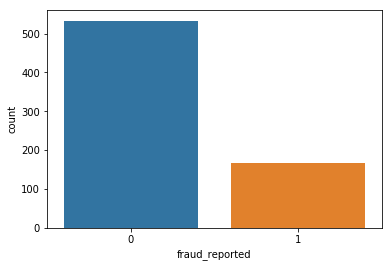

In [ ]:
chck = pd.DataFrame()
chck['fraud_reported'] = y_train

sns.countplot(chck['fraud_reported'])




## Logistic Regression

In [ ]:
lr = LogisticRegression()

lr.fit(X_train, y_train)
preds = lr.predict(X_test)

score = lr.score(X_test, y_test)
print(score)

0.74


In [ ]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.74      0.98      0.85       220
           1       0.60      0.07      0.13        80

    accuracy                           0.74       300
   macro avg       0.67      0.53      0.49       300
weighted avg       0.71      0.74      0.66       300



**Note: As pointed out in the comments, the SMOTE was applied incorrectly over all the data (training and test). It should have been applied only on train data as applying it on test data leads to data leakage. Therefore, rectifying the error and applying SMOTE only on train data.**

## Synthetic Minority Over-sampling Technique (SMOTE)

* Bir azınlık sınıfı giriş vektörü seçin
* En yakın k komşusunu bulun (k_neighbors, SMOTE() işlevinde bir argüman olarak belirtilir)
* Bu komşulardan birini seçin ve söz konusu nokta ile seçilen komşusunu birleştiren doğrunun herhangi bir yerine sentetik bir nokta yerleştirin.
* Veriler dengelenene kadar adımları tekrarlayın

![SMOTE](smt2.png)

In [ ]:
oversample = SMOTE(random_state=9)
#undersample = RandomUnderSampler(sampling_strategy=0.5,random_state=9)

In [ ]:
X_over, y_over = oversample.fit_resample(X_train, y_train)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size = 0.3, random_state = 1)

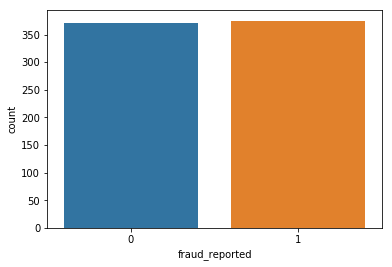

In [ ]:
chck2 = pd.DataFrame()
chck2['fraud_reported'] = y_train

sns.countplot(chck2['fraud_reported'])

We will use the LogisticRegression we defined earlier

0.98125

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       162
           1       0.97      0.99      0.98       158

    accuracy                           0.98       320
   macro avg       0.98      0.98      0.98       320
weighted avg       0.98      0.98      0.98       320



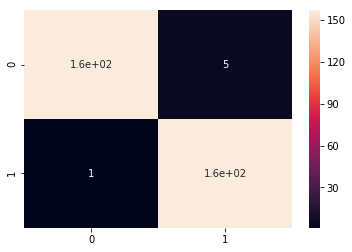

In [ ]:
lr.fit(X_train, y_train)
preds = lr.predict(X_test)
score = lr.score(X_test, y_test)
print(score)
print()
print(classification_report(y_test, preds))
cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

## Decision Tree

0.903125

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       162
           1       0.92      0.88      0.90       158

    accuracy                           0.90       320
   macro avg       0.90      0.90      0.90       320
weighted avg       0.90      0.90      0.90       320



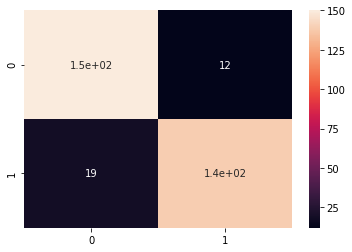

In [ ]:
dtc = DecisionTreeClassifier()

dtc.fit(X_train, y_train)
preds = dtc.predict(X_test)

score = dtc.score(X_test, y_test)
print(score)
print()
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

## There is no improvement

In [ ]:
from sklearn.ensemble import RandomForestClassifier

## Random Forest

In [ ]:
rfc = RandomForestClassifier(random_state = 1)
rfc.fit(X_train, y_train)


RandomForestClassifier(random_state=1)

90.3125

              precision    recall  f1-score   support

           0       0.85      0.98      0.91       162
           1       0.97      0.83      0.89       158

    accuracy                           0.90       320
   macro avg       0.91      0.90      0.90       320
weighted avg       0.91      0.90      0.90       320



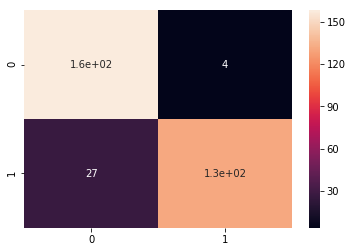

In [ ]:
preds = rfc.predict(X_test)

score = rfc.score(X_test, y_test)
print(score*100)
print()
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

## Again, no improvement

Score: 0.98125
Classification report:               precision    recall  f1-score   support

           0       0.99      0.97      0.98       162
           1       0.97      0.99      0.98       158

    accuracy                           0.98       320
   macro avg       0.98      0.98      0.98       320
weighted avg       0.98      0.98      0.98       320



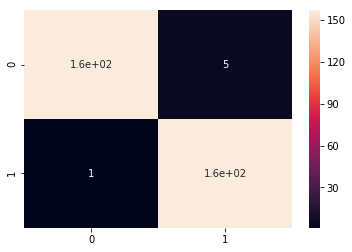

In [ ]:
#implementing 

svc = SVC(kernel='linear')
svc.fit(X_train, y_train)

preds = svc.predict(X_test)

print('Score:' , svc.score(X_test, y_test))
print('Classification report:', classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

## Using SVC with default values gave us good results with 88% accuracy.

# Hyperparameter Tuning

In SVC, we can change the kernel and degree inorder to improve our model. We will do that & see if accuracy improves.

In [ ]:

from pprint import pprint
print('Parameters currently in use:\n')
pprint(rfc.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}


* n_estimators = Ağaç Sayısı
* max_features = Bir Node'u bölmek için kullanılacak maksimum feature sayısı
* max_depth = Her bir karar ağacının maksiumum leveli
* min_samples_split = Bir Node'u bölmeden önce kullanılacak minimum nokta sayısı
* min_samples_leaf =Bir Leaf Node'da izin verilen minimum nokta sayısı
* bootstrap = Veri noktalarını örnekleme yöntemi

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 300, stop = 1000, num = 3)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [5, 17, 30, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [300, 650, 1000]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [ ]:
rf_random.best_params_

In [ ]:
rf2 = RandomForestClassifier(n_estimators=300,min_samples_split=2,min_samples_leaf=1,max_features='sqrt'
                            ,max_depth=17,bootstrap='False')
rf2.fit(X_train, y_train)

preds = rf2.predict(X_test)

score = rf2.score(X_test, y_test)
print(score*100)
print()
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

In [ ]:
df.info()

In [ ]:
df1_val=df
cat_cols = ['age_group', 'months_as_customer_groups', 'policy_annual_premium_groups','location_check','policy_deductable_group']
for col in cat_cols:
  df1_val[col] = df1_val[col].astype('object')

from sklearn.preprocessing import OneHotEncoder
encoder=OneHotEncoder(drop='first',sparse=False)
onehot=encoder.fit_transform(df1_val)

print(onehot)


In [ ]:
df1.incident_location.nunique()

In [ ]:
df2 = pd.get_dummies(df1, columns = columns_to_encode)

df2.head()

In [ ]:
cols = df2.columns
num_cols = df2._get_numeric_data().columns
list(set(cols) - set(num_cols))

In [ ]:
features = []
for col in df2.columns:
  if col != 'fraud_reported':
    features.append(col)

target = 'fraud_reported'

X_val = df2[features]
y_val = df2[target]

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_val = sc.fit_transform(X_val)

In [ ]:
X_val

In [ ]:
preds = rfc.predict(X_val)
score = rfc.score(X_val, y_val)
print(score*100)
print()
print(classification_report(y_val, preds))

cm = confusion_matrix(y_val, preds)
sns
sns.heatmap(cm, annot=True)